In [8]:
import os, math, sys, time
import numpy as np
from PIL import Image, ImageDraw
import IPython.display

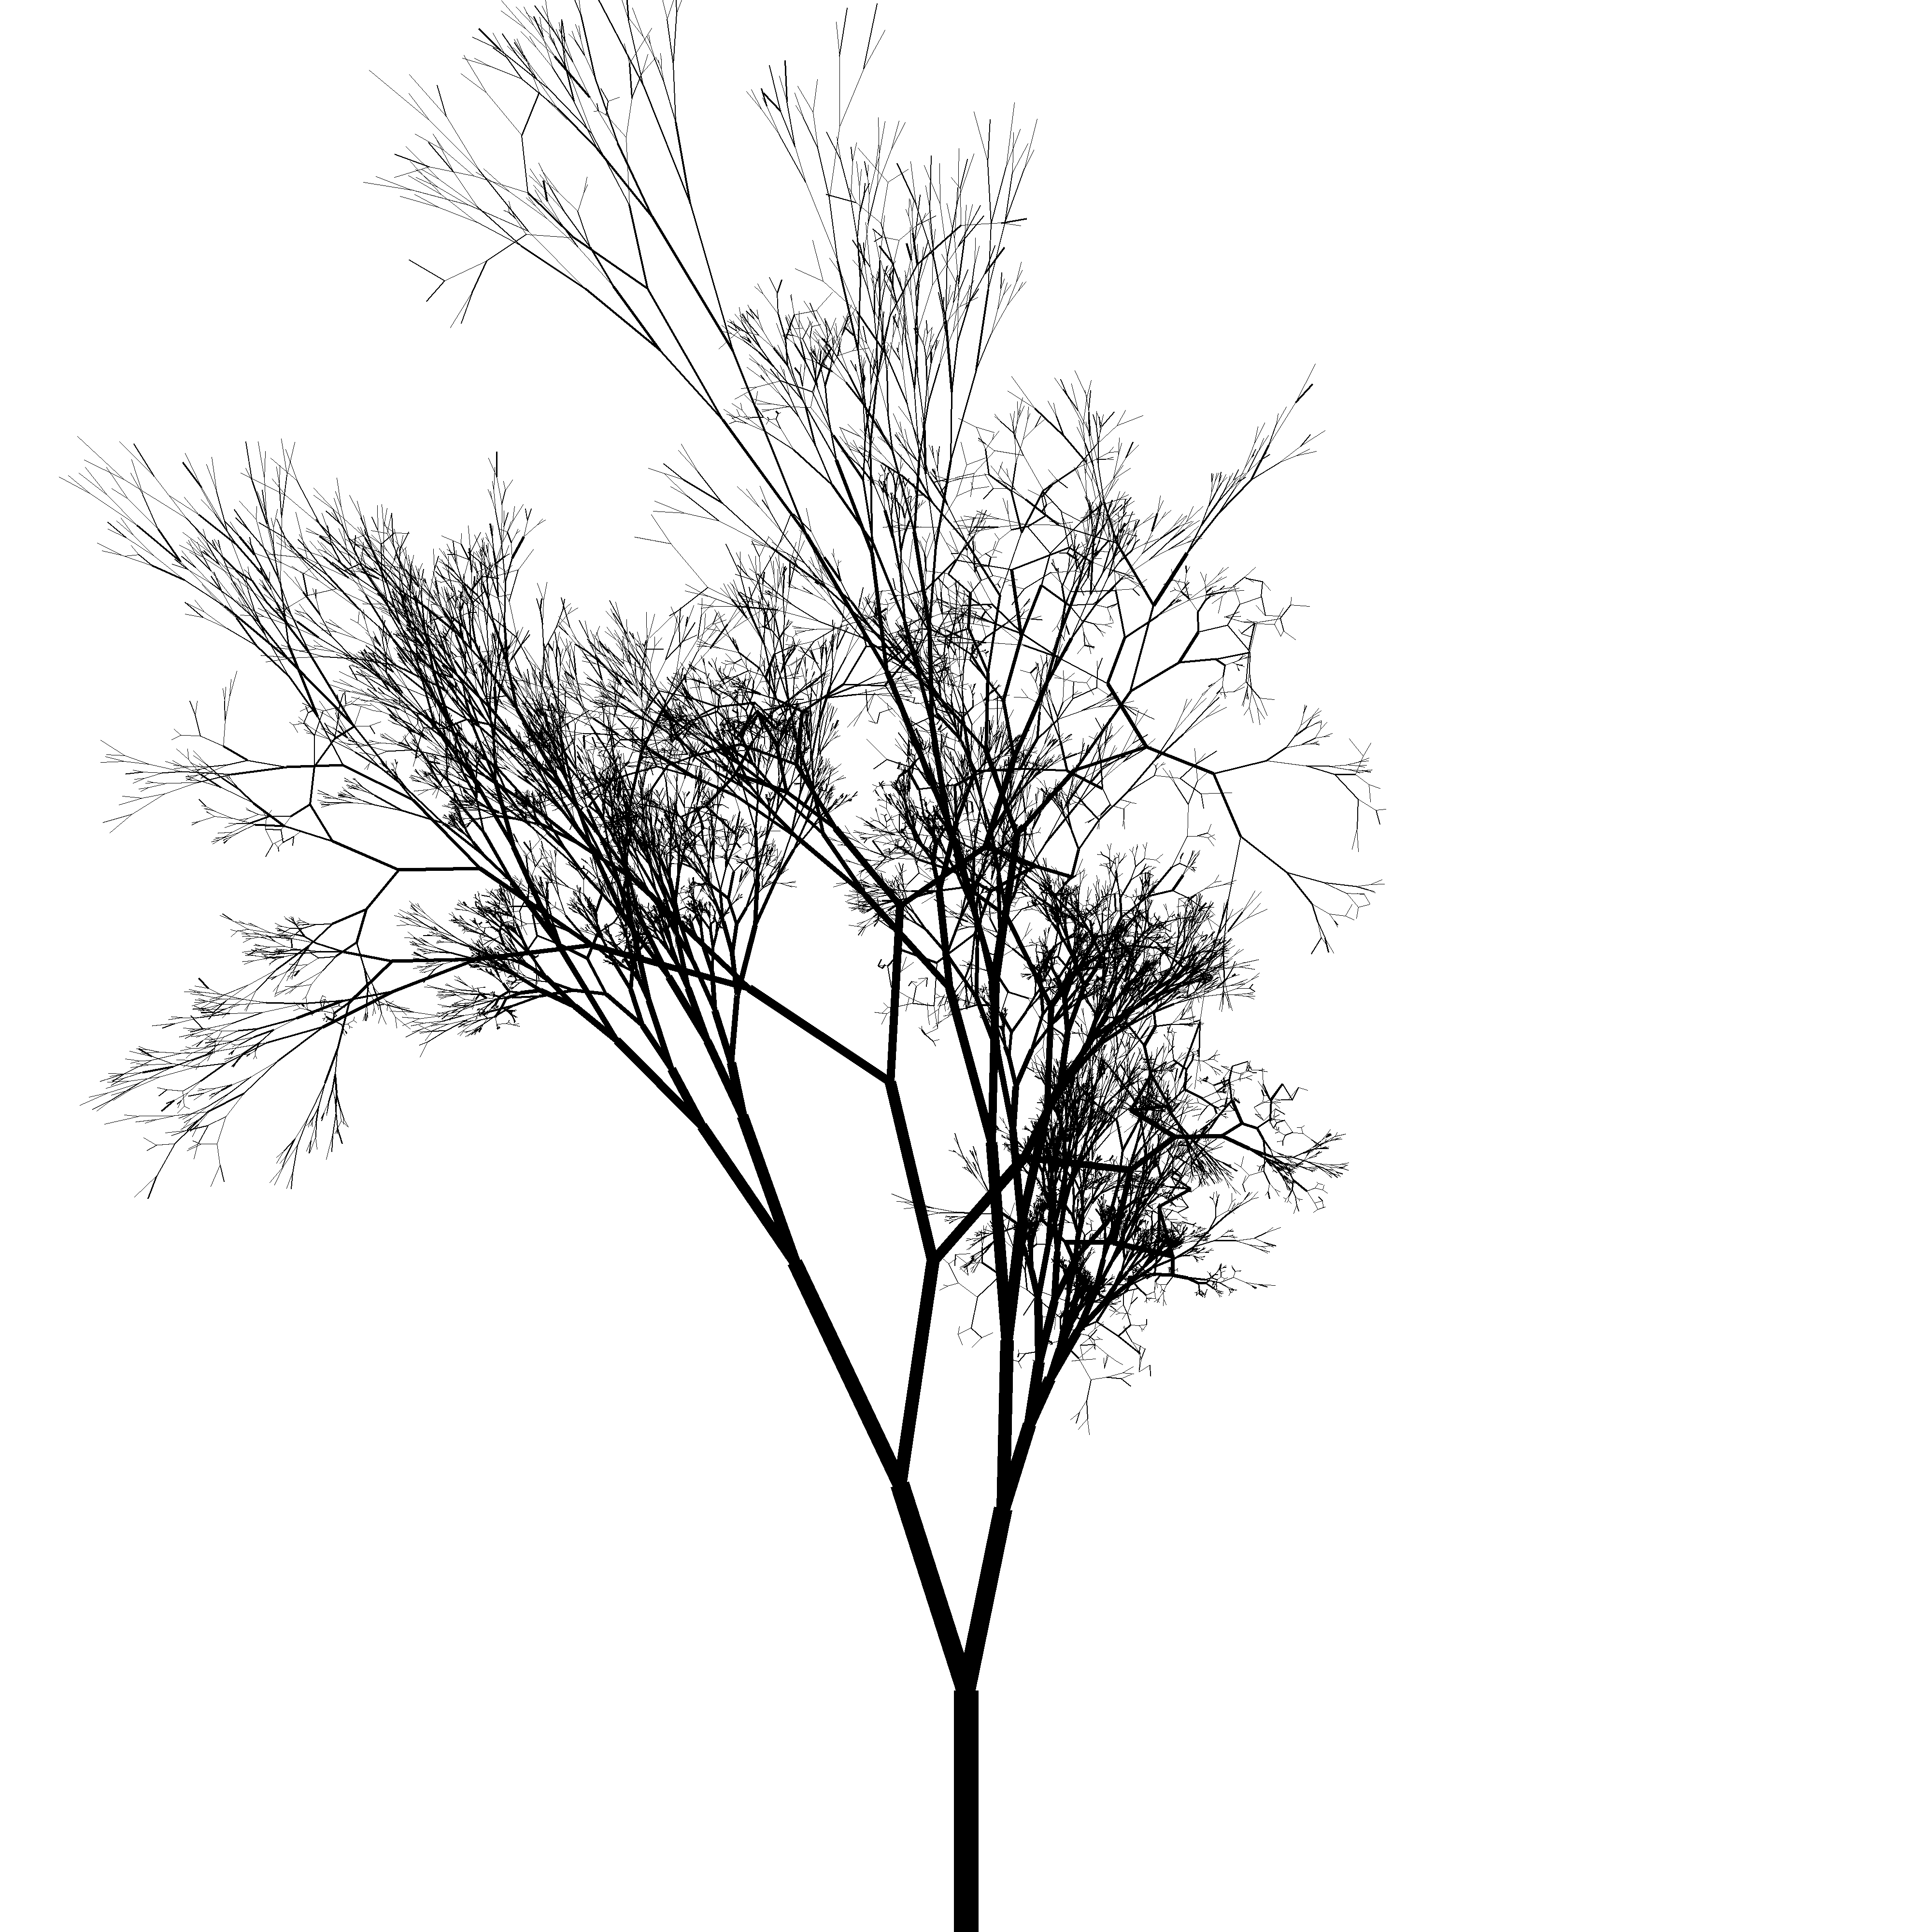

In [148]:
def mersenne(n):
    if n == 1: ls = [1]
    if n >= 2: ls = [n] + mersenne(n-1) * 2
    return ls

def floornormal(floor, mu, sigma): return np.max([floor, np.random.normal(mu, sigma)])

def fractal_tree(iter, origin, t, r, theta, dtheta):
    """
    returns a list of line begin/end coordinate tuples
    iter:     iteration number, stop when iter == 0
    origin:   x,y coordinates of the start of this branch
    t:        current trunk length
    r:        factor to contract the trunk each iteration
    theta:    starting orientation
    dtheta:   angle of the branch
    """
    if iter == 0:
        return []
    x0, y0 = origin
    x, y = x0 + t * math.cos(theta), y0 + t * math.sin(theta)
    lines = [((x0,y0), (x,y))]
    # recursive calls
    lines.extend(fractal_tree(iter-1, (x,y), floornormal(1, t * r, t * r/4.), 
                              r, theta + floornormal(0.1, dtheta, dtheta/1.8), floornormal(0.1, dtheta, dtheta/1.8)))
    lines.extend(fractal_tree(iter-1, (x,y), floornormal(1, t * r, t * r/4.), 
                              r, theta - floornormal(0.1, dtheta, dtheta/1.8), floornormal(0.1, dtheta, dtheta/1.8)))
    return lines

def draw_lines(lines, width=320, height=250):
    """draw and return the fractal tree image"""
    # create empty white image to draw on
    image1 = Image.new("RGB", (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(image1)
    i = 0
    for line in lines:
        draw.line(line, (0, 0, 0), width=int(floornormal(0,1.3**(mersenne(iter)[i]),1))) # width in pixel integers
        i+=1
    return image1
# test the functions ...

if __name__ == '__main__':
    
    width = 4000
    height = 4000
    origin = (width/2, height)

    iter = 15
    t = 500
    r = 0.75
    theta = -90. * math.pi/180.
    dtheta = 15. * math.pi/180.
    lines = fractal_tree(iter, origin, t, r, theta, dtheta)
    image1 = draw_lines(lines, width, height)
    filename="fractaltree.png"
    image1.save(filename)

time.sleep(.1)
IPython.display.Image(filename='fractaltree.png')

In [5]:
# Diffusion-Limited Aggregation (DLA) Simulation in 2D
import dye
import math, random

# --------------------------------------------------------------------
# Vector Operations. We use plain-old Python tuples for vectors.
# --------------------------------------------------------------------

vec_negate = lambda v : (-v[0], -v[1])
vec_add = lambda a, b: (a[0]+b[0], a[1]+b[1])
vec_scale = lambda v, s:  (s*v[0], s*v[1])

def vec_distance(a, b):
    x, y = a[0] - b[0], a[1] - b[1]
    return math.sqrt(x*x + y*y)

def vec_normalize(v):
    norm = math.sqrt(v[0]*v[0] + v[1]*v[1])
    return (v[0]/norm, v[1]/norm) if norm!=0 else (0, 0)

# --------------------------------------------------------------------
# A single node in the DLA network.
# --------------------------------------------------------------------

class Node(object):
    def __init__(self, pos, parent=None):
        self.pos = pos
        self.parent = parent

# --------------------------------------------------------------------
# The core DLA class
# --------------------------------------------------------------------

class DLA(object):

    def __init__(self):
        # DLA Parameters
        self.step_size = 5                            
        self.bounds_radius = 3*self.step_size
        self.collision_distance = 2*self.step_size
        # Drawing Parameters
        self.draw_nodes = True
        self.node_color = dye.RGB(0.251, 0.078, 0.098)
        self.line_color = dye.RGB(1.000, 0.119, 0.059)
        self.line_thickness = 2.0
        self.node_marker_radius = 2.0
        self.image_margin = 30.0

    def detect_collision(self):
        ''' A straight-forward but inefficient linear collision search. '''
        for n in self.nodes:
            if vec_distance(n.pos, self.loc)<=self.collision_distance:
                self.nodes.append(Node(self.loc, n))
                # If we are one step away from the bound, expand it by a step.
                if vec_distance(self.loc, (0, 0)) >= (self.bounds_radius-self.step_size):
                    self.bounds_radius += self.step_size
                # Move to a point on the bounding curve
                theta = random.uniform(0, 2*math.pi)
                self.loc = (self.bounds_radius*math.cos(theta), self.bounds_radius*math.sin(theta))
                break
            
    def generate(self, num_nodes=400):
        self.nodes = [Node((0.0, 0.0))]
        self.loc = (0.0, 0.0)
        rv = lambda: random.uniform(-1, 1)        
        while len(self.nodes)<num_nodes:
            # Random walk
            random_vec = vec_scale(vec_normalize((rv(), rv())), self.step_size)
            self.loc = vec_add(self.loc, random_vec)
            if vec_distance(self.loc, (0, 0))>self.bounds_radius:
                # We've stepped outside the bounds. Walk back in.
                self.loc = vec_add(self.loc, vec_negate(random_vec))
            self.detect_collision()

    def draw_network(self):
        for n in self.nodes:
            if n.parent is not None:
                dye.draw_line(n.parent.pos, n.pos, color=self.line_color, thickness=self.line_thickness)
        if self.draw_nodes:
            for n in self.nodes:
                dye.Oval(center=n.pos, radius=self.node_marker_radius).stroke(color=self.node_color)

    def render(self):
        w, h =  2*(2*(self.bounds_radius + self.image_margin),)
        tx, ty = 2*(self.bounds_radius + self.image_margin,)
        with dye.Image(w, h) as img:            
            with dye.translation(tx, ty):
                self.draw_network()
        return img

# --------------------------------------------------------------------
# TracingDLA: For visualizing the simulation process
# --------------------------------------------------------------------

class TracingDLA(DLA):

    def __init__(self):
        super(TracingDLA, self).__init__()
        self.walk_trace = []
        self.base_radius = self.bounds_radius
        self.trace_color = dye.RGBA(0, 0, 0, 0.1)        
        self.bound_color = dye.RGBA(0, 0, 0, 0.2)
        self.tracing_enabled = True

    def detect_collision(self):
        if (len(self.walk_trace)==0) or (self.walk_trace[-1]!=self.loc):
            self.walk_trace.append(self.loc)
        super(TracingDLA, self).detect_collision()

    def draw_network(self):
        if self.tracing_enabled:
            for point in self.walk_trace:
                dye.Oval(center=point, radius=self.node_marker_radius).fill(color=self.trace_color)
            for i in xrange(1+(self.bounds_radius - self.base_radius)/self.step_size):
                dye.Oval(center = (0, 0), radius=self.base_radius+(i*self.step_size)).stroke(self.bound_color)
        super(TracingDLA, self).draw_network()

if __name__=='__main__':
    dla = TracingDLA()
    dla.generate()
    dla.render().preview()

In [6]:
import dye
from math import ceil, sin, cos

# -----------------------------
#   Common Utility
# -----------------------------

def make_set_explorer(func, n, x0=0, y0=0):
    def set_explorer():
        x, y = x0, y0
        for i in xrange(n):
            x, y = func(x, y)
            yield (x, y)
    return set_explorer

def get_bounds(explorer):
    bounds = dye.BoundingBox()
    for p in explorer():
        bounds.expand(*p)
    return bounds

def plot_points(explorer, scale, alpha=40):
    b = dye.BoundingBox(points=explorer())
    w, h = int(ceil(scale*(b.max_x - b.min_x))), int(ceil(scale*(b.max_y - b.min_y)))
    bmp = dye.BitmapContext(w, h)
    for x, y in explorer():
        x, y = int(scale*(x-b.min_x)), int(scale*(y-b.min_y))
        bmp.composite_pixel(x, y, 0, 0, 0, alpha)
    bmp.preview()

# -----------------------------
#   The Attractors
# -----------------------------

def de_jong_attractor(a, b, c, d):
    return lambda x, y: (sin(a*y) - cos(b*x), sin(c*x) - cos(d*y))

def de_jong_variant_attractor(a, b, c, d):
    return lambda x, y: (d*sin(a*x) - sin(b*y), c*cos(a*x) + cos(b*y))

def clifford_attractor(a, b, c, d):
    return lambda x, y: (sin(a*y) + c*cos(a*x), sin(b*x) + d*cos(b*y))

# -----------------------------
#   Test Parameters
# -----------------------------

de_jong_params = (1.4, -2.3, 2.4, -2.1)
de_jong_variant_params = (1.4, 1.56, 1.4, -6.56)
clifford_params = (1.5, -1.8, 1.6, 0.9)

if __name__=='__main__':
    attractor = de_jong_attractor(*de_jong_params)
    explorer = make_set_explorer(attractor, n=1000000)
    plot_points(explorer, scale=100)

In [21]:
import turtle
t=turtle.Turtle()
def f(w):
    if w>=1:
        s=t.pensize()
        t.pensize(w)
        t.fd(w*9)
        t.rt(20)
        f(w*.75)
        t.lt(40)
        f(w*.75)
        t.right(20)
        t.bk(w*9)
        t.pensize(w)
t.speed(90000)
f(3)
t.ht()
raw_input()

Terminator: 